<a href="https://colab.research.google.com/github/markustoivonen/AIHealthTech2020/blob/master/exercises/ex8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.1

Tokenization is breaking a text chunk in smaller parts. Whether it is breaking a paragraph in to sentences, sentence into words or word in characters. \\

Subword tokenization means breaking words into a corpus and a subword. For example the word "faster" becomes "fast", "er". Thus we can learn the subwords as well.


## 1.2

One-hot encoding is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). If we have a vocabulary of 10k words, and we one-hot encode each word, we would create a vector where 99.99\% of the elements are zero. \\

Embedding allows us to represent the words in a more dense way. The idea is that we project the words in our vocabulary into some space, and the mapping tries to put similar words close to each other in the space. Embedding is also something we can also improve by training. These 3 things (dense representation, relationships between words, trainability) make it much more better encoding mechanic than one-hot encoding.


## 1.3

The embeddings seem to make a little sense. For example close to one another are airport, runaway, petroleum, import and export. And in another corner there seems to be a lot of names bundles together. However, considering the first three axises only explain 8.5\% of the variance, one should not draw too many conclusions from the relationships. 

# Self Attention

Self attention is a mechanism made popular by the paper "Attention Is All You Need" https://arxiv.org/abs/1706.03762. The mechanism requires three components: Queries $Q$, Keys $K$, and Values $V$. Queries and Keys are matrices with sequence_length $\times$ element_dimension elements. An attention matrix is produced by computing $QK^T$ with dimensions sequence_length $\times$ sequence_length. Conceptually this can be thought to measure the similarity of the vectors located at each sequence element in the queries and keys. A row-wise softmax is then taken and the matrix is multiplied with the values. This can be thought to first introduce weights which sum up to one (the softmaxed matrix) and then a weighted sum of the sequence elements is taken. Certain sequence elements can thus dominate the output and irrelevant parts are suppressed.

The self attention is often made as follows:
Let $x$ be a matrix with dimensions sequence_length $\times$ input_dimension, where input_dimension is for example the output of a hidden layer and sequence length is the length of a time-series etc.

\begin{align}
Q &= xw_Q\\
K &= xw_K\\
V &= xw_V\\
SelfAttn(Q,K,V) &= Softmax_{r}(QK^T)V
\end{align}
Here the $Softmax_{r}$ is the softmax taken row-wise (each element exponentiated and then normalized via the sum of the exponentiated elements).
The weights $w_Q,w_K$ have dimensions input_dimension$\times$element_dimension and the $w_V$ is either the same shape or the element_dimension can also be different. Often the $SelfAttn(\cdot)$ also includes a normalizing constant inside the softmax to make the learning more stabile. For example in the paper "Attention Is All You Need" the self attention is given by:

\begin{equation}
SelfAttn(Q,K,V) = Softmax_{r}(\frac{QK^T}{\sqrt{d_e}})V
\end{equation}
Where $d_e$ is the element_dimension (their notation is slightly different).

Usually the self attention is followed by fully connected layers which map the output to either classification probabilities or to the input of another attention layer.



In [29]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.data import Dataset
import matplotlib.pyplot as plt

In [30]:
data = tfds.load(name='tiny_shakespeare')
train_examples, val_examples = tfds.as_numpy(data['train']), tfds.as_numpy(data['validation'])

In [31]:
def process_shakespeare_to_batches(ds_in,sequence_length=101):
    # Extract the data from the dataset object:
    ds = next(iter(ds_in))['text']
    # Decode the bytes as utf-8 string:
    ds = ds.decode('UTF-8')
    # Remove linebreaks from the text unless speaker changes:
    ds = ds.split('\n\n')
    ds = [item.replace('\n',' ') for item in ds]
    ds = " \n ".join(ds)
    # We are going to chunk the string into sequences of 500 characters:
    ds_new = []
    i = 0
    while i<len(ds):
        my_string = ds[i:i+sequence_length]
        if len(my_string)<sequence_length:
            break # A quick and dirty way to make it so that all elements are 500 long
        ds_new.append(my_string)
        i+=sequence_length
    ds = ds_new
    return ds


In [32]:
# Chunk the play into suitable components:
sequence_length = 101
train_dataset = process_shakespeare_to_batches(train_examples,sequence_length=sequence_length)
val_dataset = process_shakespeare_to_batches(val_examples,sequence_length=sequence_length)
print("Number of training examples: %d, and number of validation examples: %d"%(len(train_dataset),len(val_dataset)))

Number of training examples: 10001, and number of validation examples: 556


In [33]:
# Now we have our datasets as lists of text.
# Next we need to do 2 things, make them into tensorflow datasets and tokenize
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',char_level=True,split=None)
tokenizer.fit_on_texts(train_dataset)
vocab_size = len(list(eval(tokenizer.get_config()['index_word']).keys()))+1 # One for unknown
print("Vocab size: %d"%vocab_size)
train_seqs = tokenizer.texts_to_sequences(train_dataset)
val_seqs = tokenizer.texts_to_sequences(val_dataset)

Vocab size: 40


In [34]:
# Since the keras tokenizer will concat always with space, we need to do our own backward tokenizer:
def sequences_to_text(dataset,tokenizer):
    index_word = eval(tokenizer.get_config()['index_word']) # I have absolutely no idea why the keras devs think its good idea to store this dict as a string as there is no other way to access this.
    dataset_text = []
    for batch in dataset:
        my_sequence = []
        for character_token in batch:
            my_sequence.append(index_word[str(character_token)])
        dataset_text.append("".join(my_sequence))
    return dataset_text

In [35]:
# Test if we can map the words back:
print("Original sequence:")
print(train_dataset[0])
print('\n')
tr_seq_2_text = sequences_to_text(train_seqs,tokenizer)
print("Tokenized and back mapped sequence:")
print(tr_seq_2_text[0])

Original sequence:
First Citizen: Before we proceed any further, hear me speak. 
 All: Speak, speak. 
 First Citizen: Yo


Tokenized and back mapped sequence:
first citizen: before we proceed any further, hear me speak. 
 all: speak, speak. 
 first citizen: yo


In [36]:
# Almost done! Now we just need to form the datasets.
# Let's make it so that we always want to predict one token ahead.
# Thus input is all but last token in original positions, but target is all but first token in left shifted positions
train_inputs = [item[0:-1] for item in train_seqs]
train_targets = [item[1:] for item in train_seqs]

val_inputs = [item[0:-1] for item in val_seqs]
val_targets = [item[1:] for item in val_seqs]

batch_size = 32
train_dataset = Dataset.from_tensor_slices((train_inputs, train_targets)).shuffle(9999).batch(batch_size)
validation_dataset = Dataset.from_tensor_slices((val_inputs, val_targets)).batch(batch_size)

# Task 1.

In this code we are going to train a simple model utilizing the self-attention blocks. The model is based on the Transformer model, but is slightly more simple.

Finish the code for the self attention block "SelfAttentionLayer" in the following cell.

You can call "tf.matmul" to perform matrix multiplication on batches of matrices to compute the $QK^\top$ and the final output.

Notice that we **need** to use masking as we are predicting the next token, otherwise this information will be leaked. Call the causal_softmax function inplace of the softmax used in the normal equations.

In [45]:
@tf.function
def causal_softmax(x,eps=1e-6):
    # Assume x is of shape batch_size,sequence_length,sequence_length
    # Generate a lower diagonal matrix of ones. First row has ones only at first element, second at first and second, and so on.
    mask = tf.linalg.band_part(tf.ones((x.shape[1], x.shape[1])), -1, 0)
    # In essence this could be just computed as exp(x)*mask/(sum(exp(x)*mask))
    # However, here we utilize the numerically stabile version where we take the max out of the exponentiated matrix, which requries two maskings
    # exp(x_j)/sum_i(exp(x_i)) = (exp(-x_max)*exp(x_j))/(exp(-x_max)*sum_i(exp(x_i))) = exp(x_j-x_max)/sum_i(x_i-x_max)
    x = x*mask
    maxx = tf.math.reduce_max(x,axis=2,keepdims=True)
    x = x-maxx
    x = tf.math.exp(x)*mask # We need to mask outside exp, since exp(0) = 1
    x = x/(tf.math.reduce_sum(x,axis=2,keepdims=True)+eps)
    return x


"""
TASK IS TO COMPLETE THE NEXT:
"""
class SelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dimension):
        super(SelfAttentionLayer, self).__init__()
        self.QMapping = layers.Dense(embedding_dimension)
        self.KMapping = layers.Dense(embedding_dimension)
        self.VMapping = layers.Dense(embedding_dimension)
    
    def call(self, input):
        # Complete this call using the equations given.
        # tf.matmul computes the matrix multiplication in batch mode if there is 3 dimensions so it is suitable.
        # Also let's say we want to compute M1 * M2^T (M1 times M2 transposed)
        # We can compute it using tf.matmul(M1,M2,transpose_b=True)
        Q = self.QMapping(input)
        K = self.KMapping(input)
        V = self.VMapping(input)
        # d_e is scaling as is shown above and in the paper.
        d_e = tf.cast(tf.shape(K)[-1], tf.float32)
        QK_t = tf.matmul(Q, K, transpose_b=True)
        attention_weights = causal_softmax(QK_t)
        output = tf.matmul(attention_weights, V)
        return output
"""
END
"""

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttentionLayer(embedding_dim)
        self.fc1 = layers.Dense(embedding_dim, activation='relu')
        self.fc2 = layers.Dense(embedding_dim, activation='relu')
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
    def call(self, x, training):
        attended = self.attention(x)
        attended = self.dropout1(attended,training=training)
        attended_normed = self.layernorm1(x+attended)
        feed_forwarded = self.fc2(self.fc1(attended_normed))
        feed_forwarded = self.dropout2(feed_forwarded,training=training)
        output = self.layernorm2(feed_forwarded + attended_normed)
        return output

class MiniTransformer(tf.keras.Model):
    def __init__(self,number_of_tokens,embedding_dim=256):
        super(MiniTransformer, self).__init__()
        # Embed the inputs to embedding_dim trainable vectors:
        self.embedding = layers.Embedding(number_of_tokens, embedding_dim)
        self.tblock1 = TransformerBlock(embedding_dim)
        self.tblock2 = TransformerBlock(embedding_dim)
        self.tblock3 = TransformerBlock(embedding_dim)
        self.tblock4 = TransformerBlock(embedding_dim)
        self.tblock5 = TransformerBlock(embedding_dim)
        # Now map probabilities for each token
        self.classifier = layers.Dense(number_of_tokens)
    def call(self, x, training, as_logits = True):
        x = self.embedding(x,training=training)
        x = self.tblock1(x,training=training)
        x = self.tblock2(x,training=training)
        x = self.tblock3(x,training=training)
        x = self.tblock4(x,training=training)
        x = self.tblock5(x,training=training)
        if as_logits:
            return self.classifier(x)
        else:
            return tf.keras.activations.softmax(self.classifier(x), axis=-1)

In [46]:
# make the model:
mini_transformer = MiniTransformer(vocab_size,embedding_dim=512)

In [47]:
learning_rate = 0.0003
mini_transformer.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

In [60]:
# Train and use the early stopping hook:
epochs = 50
history = mini_transformer.fit(train_dataset,
                               epochs=epochs,
                               validation_data=validation_dataset,
                               callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                          min_delta=0,
                                                                          patience=10, 
                                                                          restore_best_weights=True))

Epoch 1/50
313/313 [==============================] - 47s 150ms/step - loss: 2.3003 - accuracy: 0.3065 - val_loss: 2.3118 - val_accuracy: 0.3019
Epoch 2/50
313/313 [==============================] - 47s 150ms/step - loss: 2.2904 - accuracy: 0.3091 - val_loss: 2.3090 - val_accuracy: 0.3038
Epoch 3/50
313/313 [==============================] - 47s 149ms/step - loss: 2.2941 - accuracy: 0.3077 - val_loss: 2.3133 - val_accuracy: 0.3020
Epoch 4/50
313/313 [==============================] - 46s 148ms/step - loss: 2.2935 - accuracy: 0.3077 - val_loss: 2.3238 - val_accuracy: 0.2987
Epoch 5/50
313/313 [==============================] - 47s 149ms/step - loss: 2.2904 - accuracy: 0.3088 - val_loss: 2.3108 - val_accuracy: 0.3047
Epoch 6/50
313/313 [==============================] - 47s 149ms/step - loss: 2.2818 - accuracy: 0.3114 - val_loss: 2.3098 - val_accuracy: 0.3019
Epoch 7/50
313/313 [==============================] - 47s 149ms/step - loss: 2.2791 - accuracy: 0.3116 - val_loss: 2.2990 - val_ac

Text(0.5, 1.0, 'Training and Validation Accuracy')

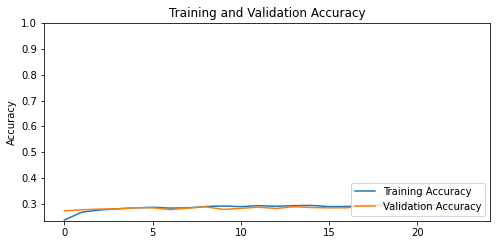

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

In [50]:
# Generate text using the model. Here are some utility functions which you can use.
def complete_string(model,init_string,sequence_length,tokenizer=tokenizer):
    prediction_index = len(init_string)-1
    data = [init_string]
    sequence = tokenizer.texts_to_sequences(data)
    # We want to generate the string by predicting one step ahead, and then
    # appending the t+1 predicted token into the sequence:
    while prediction_index < sequence_length:
        probabilities = model(tf.convert_to_tensor(sequence, dtype=tf.float32),training=False,as_logits=False)
        # probabilities is 1 x sequence_length x number_of_tokens.
        # Get the predictions on the next token by:
        p_next = probabilities[0,prediction_index,:].numpy()

        # There might be some floating point errors, which numpy does not like.
        # Thus do this:
        p_next = p_next.astype('float64')
        p_next = p_next/np.sum(p_next)

        # Often it is better to sample the next token rather than to use the one with maximum probability:
        pred_next = np.argmax(np.random.multinomial(1,p_next))
        sequence[0].append(pred_next)
        prediction_index = len(sequence[0])-1
    
    return sequences_to_text(sequence,tokenizer)[0]

# Task 2
Generate different strings using the model by changing the "string_to_complete" to something else.
What can you say about the quality of the generated strings? What happens if you feed some "out-of-distribution" initial string? For example there is probably nothing about AI in Shakespeare...

In [54]:
# Modify this string and run this cell to make the model generate ending to the initial string.
string_to_complete = "Artificial Intelligence is "
completed_string = complete_string(mini_transformer,init_string=string_to_complete,sequence_length=50)
print(completed_string)

artificial intelligence is maso: wa merelyansouimel


In [55]:
string_to_complete = "The meaning of life is to "
completed_string = complete_string(mini_transformer,init_string=string_to_complete,sequence_length=50)
print(completed_string)

the meaning of life is to gro wilothe o bere fe yor


In [58]:
string_to_complete = "The next president of the United States is "
completed_string = complete_string(mini_transformer,init_string=string_to_complete,sequence_length=55)
print(completed_string)

the next president of the united states is wi ac s to ie
